# Препроцессинг диалогов Telecom

In [1]:
import sys
sys.path.append("../../")

In [2]:
import warnings
import logging
import pandas as pd
import json
import sys

import os

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from analytics_lib.notebooks.API import api

logging.disable(sys.maxsize)
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [ ]:
def plot_one(public_df):
    list_of_text_features = public_df._get_numeric_data().columns.values.tolist()
    list_of_text_features.reverse()
    n = len(list_of_text_features)
    plt.rcParams["figure.figsize"] = (20, n)
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    fig, ax = plt.subplots((n // 2 + n % 2), 2)
    for i in range(n // 2 + n % 2):
        for j in range(2):
            try:
                feature_name = list_of_text_features.pop()
            except:
                break
            x = public_df[f"{feature_name}"].to_list()
            sns.kdeplot(data=x, fill = True, ax = ax[i][j], palette = pal, cut = 0)
            ax[i][j].set_title(f"{feature_name}", y=1.0, pad=-14, fontsize=16)
            ax[i][j].set_xlabel(f'Значение признака', fontsize=13)
            ax[i][j].set_ylabel(f'Доля людей', fontsize=13)
            ax[i][j].axvline(x=np.quantile(x, q=0.2), c='yellow')
            ax[i][j].axvline(x=np.quantile(x, q=0.4), c='green')
            ax[i][j].axvline(x=np.quantile(x, q=0.6), c='blue')
            ax[i][j].axvline(x=np.quantile(x, q=0.8), c='red')
    fig.tight_layout()
    plt.show()

In [3]:
with open('../data/telecom/telecom.json', mode='r') as f:
    dict_texts_telecom = json.load(f)

In [4]:
STOP_REPLICS = ['ScoreBad_BTN37', 'ScoreRequest_BTN39', 'ScoreExcellent_BTN10',\
                'notOK_BTN50', '<file attachment>', '/start',\
                'Scenario_19042020_115033_0024', 'Scenario_19042020_115033_0003',\
                'тест', 'Тест']
FILTER_IN_REPLICS = ['ScoreRequest_BTN39'] #u"<br>", u"\xa0", u"\u200b", 

In [5]:
%%time
list_all_clients_texts = []
list_all_clients_replics = []

dict_all_telecom_texts = {}
for i in range(len(dict_texts_telecom['calls'])):
    list_client_speechs = dict_texts_telecom['calls'][i]['chat_transcript']['client']
    list_client_replics = [dict_speech['phrase'] for dict_speech in list_client_speechs\
                                if dict_speech['phrase'] not in STOP_REPLICS and\
                                'Scenario_' not in dict_speech['phrase'] and \
                                len(dict_speech['phrase']) >= 7]
    list_all_clients_replics += list_client_replics
    client_text = " ".join(list_client_replics)
    
    for stop_word in FILTER_IN_REPLICS:
        client_text = client_text.replace(stop_word, '')
    if not client_text or len(client_text) < 300:
        continue
        
    list_all_clients_texts.append(client_text)
    dict_all_telecom_texts[dict_texts_telecom['calls'][i]['id']] = client_text

CPU times: user 9.27 ms, sys: 504 µs, total: 9.78 ms
Wall time: 9.53 ms


In [15]:
list_texts_lens = []
for text in list_all_clients_texts:
    list_texts_lens.append(len(text))
    
list_replics_lens = []
for replic in list_all_clients_replics:
    list_replics_lens.append(len(replic))

In [6]:
# pd.read_pickle("../data/telecom/public_dict_with_distances.pkl")[text][2]

In [7]:
# df = pd.read_pickle("../data/telecom/public_df.pkl")
# df[df['Текст'] == text].reset_index(drop=True)

In [9]:
%%time
dict_res = {}
ind = 0
for _id in tqdm(dict_all_telecom_texts.keys()):
    text = dict_all_telecom_texts[_id]
    dict_one_res = api(text=text, quantiles='dialogs', ind=ind)
    dict_res[_id] = dict_one_res
    ind += 1

100%|███████████████████████████████████████████████████████████████████████████████████| 459/459 [24:29<00:00,  3.20s/it]

CPU times: user 24min 9s, sys: 20.2 s, total: 24min 29s
Wall time: 24min 29s


In [11]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
with open('dict_res_telecom.json', 'w', encoding='utf-8') as f:
    json.dump(dict_res, f, ensure_ascii=False, cls=NpEncoder)

In [8]:
# dict_res['7d1e4f5e-162f-4777-b80f-f9ef6c69cd3f'].keys()

In [7]:
# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)
    
# dict_temp = {'Текст': dict_res['7d1e4f5e-162f-4777-b80f-f9ef6c69cd3f']['Текст']}
# for key in ['Индикаторы темпераментов в разрезе признаков по тексту']:
#     dict_temp[key] = dict_res['7d1e4f5e-162f-4777-b80f-f9ef6c69cd3f'][key]
# with open('dict_res_telecom.json', 'w', encoding='utf-8') as f:
#     json.dump(dict_temp, f, ensure_ascii=False, indent=10, cls=NpEncoder)

In [37]:
# import pickle
# with open('dict_res_telecom.pkl', 'wb') as f:
#     pickle.dump(dict_res, f)

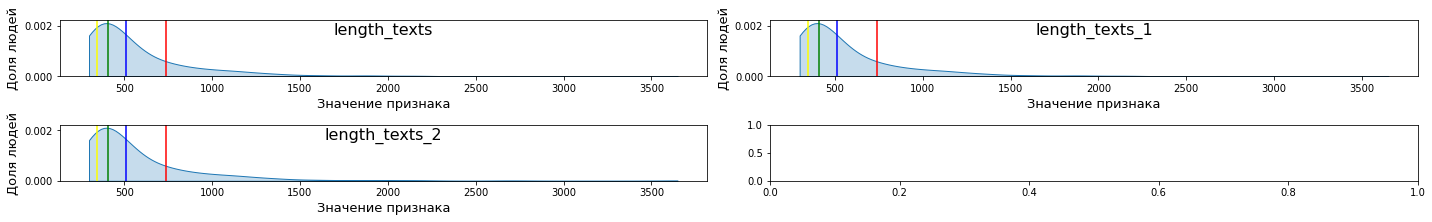

In [17]:
df_lens = pd.DataFrame(list_texts_lens, columns=['length_texts'])
df_lens['length_texts_1'] = list_texts_lens
df_lens['length_texts_2'] = list_texts_lens
plot_one(df_lens)

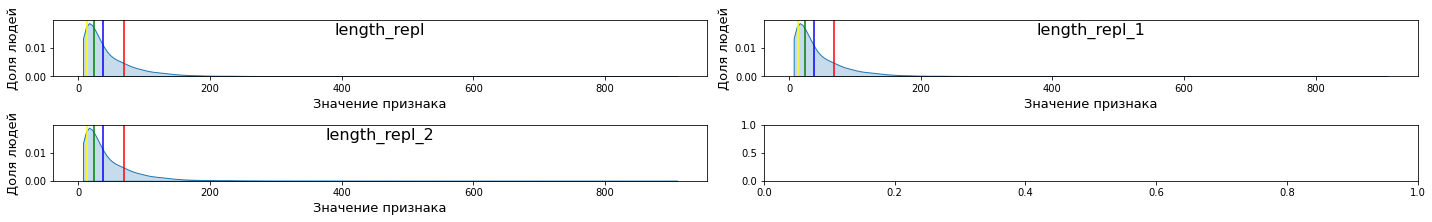

In [18]:
df_lens_repl = pd.DataFrame(list_replics_lens, columns=['length_repl'])
df_lens_repl['length_repl_1'] = list_replics_lens
df_lens_repl['length_repl_2'] = list_replics_lens
plot_one(df_lens_repl)

In [12]:
dict_lens = {}
for text in list_all_clients_replics:
    dict_lens[text] = len(text)
    
{k: v for k, v in sorted(dict_lens.items(), key=lambda item: item[1], reverse=False)}

{'Отлично': 7,
 'Спасибо': 7,
 'Оплатил': 7,
 'Сделала': 7,
 'Переезд': 7,
 'как мне': 7,
 'Онлайн\xa0': 7,
 'кошмар\xa0': 7,
 'Конечно': 7,
 'переезд': 7,
 'Хорошо\xa0': 7,
 'вы тут?': 7,
 'Я здесь': 7,
 'понятно': 7,
 'спасибо': 7,
 'Пришёл?': 7,
 'Хорошо☺': 7,
 'хорошо\xa0': 7,
 'Понятно': 7,
 'не верю': 7,
 'Чёрт...': 7,
 'неважно': 7,
 'В 12.56': 7,
 'Ужас!!!': 7,
 '😁👎🏽👎🏽👎🏽': 7,
 'секунду': 7,
 'Николай': 7,
 'Алексей': 7,
 'Роутер\xa0': 7,
 'Сейчас\xa0': 7,
 'еще нет': 7,
 'Я понял': 7,
 'Добрый\xa0': 7,
 'Юшин ИВ': 7,
 'сетевая': 7,
 'Надежда': 7,
 '385 603': 7,
 'На асех': 7,
 'спасиьо': 7,
 'Г Химки': 7,
 'Почему?': 7,
 'а плачУ': 7,
 'почему?': 7,
 'Евгений': 7,
 'Привет\xa0': 7,
 'Включил': 7,
 'Почему\xa0': 7,
 'Поняла\xa0': 7,
 'В 23:10': 7,
 'Ок, жду': 7,
 'Юсов АС': 7,
 'Не знаю': 7,
 'windows': 7,
 'Netgear': 7,
 'Сделано': 7,
 'Зачем??': 7,
 'давайте': 7,
 'Премиум': 7,
 'Добрый!': 7,
 '0105593': 7,
 'Завтра?': 7,
 'И что??': 7,
 'Спасбо!': 7,
 'Секунду': 7,
 'Опять??'

In [19]:
dict_lens = {}
for text in list_all_clients_texts:
    dict_lens[text] = len(text)
    
{k: v for k, v in sorted(dict_lens.items(), key=lambda item: item[1], reverse=False)}

{'Здравствуйте, есть какая-то новая информация/сроки по восстановлению интернета? по адресу Химки, Горшина 8, кв. 138, лицевой счет 10117126 Здравствуйте, есть какая-то новая информация/сроки по восстановлению интернета? по адресу Химки, Горшина 8, кв. 138, лицевой счет 10117126Не ответили. Писал днем': 300,
 'Добрый вечер\xa0 А что происходит с интернетом?\xa0 Уже несколько дней подряд наблюдаю не понятные скачки, то он есть то его нет... с чем это связано? Мельник Андрей Юрьевич\xa010136252 Он вроде есть но толком не грузит, потом просто пропадает\xa0 Не помогает Если и помогает то не на долго Я выхожу\xa0 с телефона\xa0': 300,
 'здравствуйте лс счет\n10115335\nпосмотрите пожалуйста, какой статус сейчас интернет не работает, не могу понять, то-ли не оплачено, то-ли сбой какой-то технический Шехонин Евгений Владимирович да, спасибо, всё работает добрый вечер ЛС 10115335 - не работает интернет, подскажите, какая-то авария у вас?': 300,
 'Доброе утро\xa0 Подскажите пожалуйста,я планирую